# Digital Image Processing, Homework 3

## Ashkan Zarkhah - 610399196

In this assignment, we use TensorFlow and Keras to download pre-trained CNN models like ResNet, VGGNet, EfficientNet, MobileNet, DenseNet, and ConvNet (2022). Additionally, we use PyTorch to build a GoogleNet model from scratch and train it.


## Imports

In [13]:
#Imports
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense,Flatten
from keras.datasets import cifar10
import cv2
from keras import backend as K
from keras.optimizers import SGD
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, confusion_matrix
import gc
from keras.utils import to_categorical
from tensorflow.keras.models import load_model

In [2]:
#Category names for visualization
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## Data Loader

In [3]:
#Loading data and splitting it into train, test, and validation
def Data_loader():
    (X_train, y_train) , (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    return (X_train, y_train, X_val, y_val, X_test, y_test)

(X_train, y_train, X_val, y_val, X_test, y_test) = Data_loader()
X_test_for_display = X_test

170500096/170498071 [==============================] - 6s 0us/step


## Visaulization tool

In [14]:
# utility to display a row of images with their predictions
def display_images(X, y_pred, y, n):
  indexes = np.random.choice(len(y_pred), size=n)
  images = X[indexes]
  preds = y_pred[indexes]
  labels = y[indexes]

  preds = preds.reshape((n,))
  labels = labels.reshape((n,))
 
  fig = plt.figure(figsize=(3 * n, 4))
  plt.yticks([])
  plt.xticks([])

  for i in range(n):
    ax = fig.add_subplot(1, n, i+1)
    class_index = preds[i]
    
    plt.xlabel("Predicted label : " + classes[class_index] +  "\n" + "True label : " + classes[labels[i]])
    #plt.ylabel()
    plt.xticks([])
    plt.yticks([])
    plt.imshow(images[i])

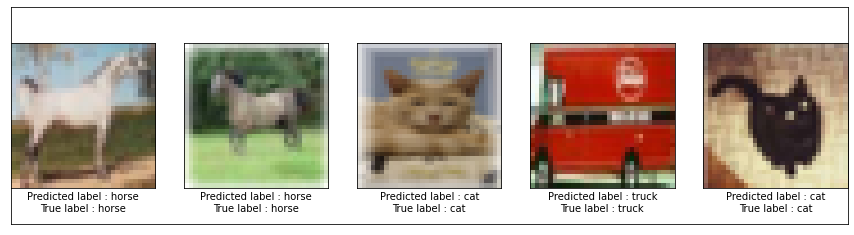

In [5]:
#Displaying some images
display_images(X_train, y_train, y_train, 5)

## Evaluation Tool

In [6]:
#Developing a function to evaluate models
def Model_evaluator(model, X_test, y_test):
    y_pred = model.predict(X_test, batch_size=64)
    y_pred = np.argmax(y_pred, axis = 1)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    
    #Displaying some images
    display_images(X_test_for_display, y_test, y_pred, 5)


## Pre-trained CNN Models with TensorFlow and Keras

### ResNet50

For the preprocessing, we use `resnet.preprocess_input` to convert the input images from RGB to BGR, and then to zero-center each color channel with respect to the ImageNet dataset, without scaling.

For the model, we first add a resize layer to resize images into 224x224, and then we add 3 dense layers at the end of the model.

In separate parameter tunings, we found that the best parameters are:
- Optimizer: SGD
- Number of epochs: 5
- Batch size: 64


## Preprocessing

In [7]:
#Preprocessing for Resnet 50
def ResNet50_preprocess(input_images):
    input_images = input_images.astype('float32')
    output_images = tf.keras.applications.resnet50.preprocess_input(input_images)
    return output_images

X_train = ResNet50_preprocess(X_train)
X_val = ResNet50_preprocess(X_val)
X_test = ResNet50_preprocess(X_test)

## Model Definition

In [11]:
#Developing ResNEt 50 model
def ResNet50_model():
    inputs = tf.keras.layers.Input(shape=(32,32,3))
    resized = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    base_model = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(resized)
    
    new_leyers = tf.keras.layers.GlobalAveragePooling2D()(base_model)
    new_leyers = tf.keras.layers.Flatten()(new_leyers)
    new_leyers = tf.keras.layers.Dense(512, activation="relu")(new_leyers)
    new_leyers = tf.keras.layers.Dense(128, activation="relu")(new_leyers)
    new_leyers = tf.keras.layers.Dense(10, activation="softmax", name="classification")(new_leyers)

    model = tf.keras.Model(inputs=inputs, outputs = new_leyers)
    model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
    return model


model = ResNet50_model()
model.summary()

94773248/94765736 [==============================] - 0s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_______________________________________________________

## Training

In [12]:
#Learning Resnet50 model
EPOCHS = 5
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data = (X_val, y_val), batch_size=64)
model.save("/kaggle/working/ResNet50.h5")

Epoch 1/5
625/625 [==============================] - 204s 326ms/step - loss: 0.4530 - accuracy: 0.8498 - val_loss: 0.2478 - val_accuracy: 0.9139
Epoch 2/5
625/625 [==============================] - 203s 325ms/step - loss: 0.1138 - accuracy: 0.9623 - val_loss: 0.1746 - val_accuracy: 0.9408
Epoch 3/5
625/625 [==============================] - 203s 324ms/step - loss: 0.0367 - accuracy: 0.9899 - val_loss: 0.1820 - val_accuracy: 0.9434
Epoch 4/5
625/625 [==============================] - 203s 324ms/step - loss: 0.0145 - accuracy: 0.9971 - val_loss: 0.1761 - val_accuracy: 0.9459
Epoch 5/5
625/625 [==============================] - 203s 324ms/step - loss: 0.0074 - accuracy: 0.9988 - val_loss: 0.1764 - val_accuracy: 0.9485


## Evaluating

Accuracy: 0.9489
Precision: 0.9489
Recall: 0.9489
F1 Score: 0.9488


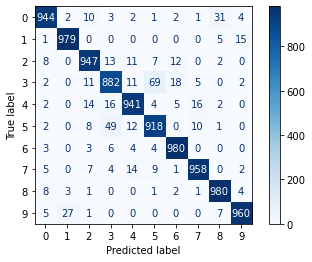

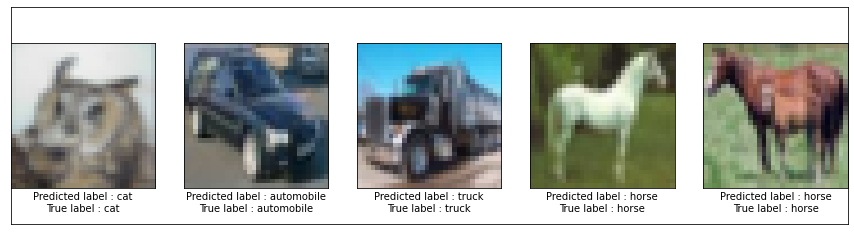

In [19]:
#Evaluating resnet50 model
#model = load_model("/kaggle/working/ResNet50.h5")
Model_evaluator(model, X_test, y_test)

In [32]:
#Loading Data over
(X_train, y_train, X_val, y_val, X_test, y_test) = Data_loader()


### VGGNet19

For the preprocessing, we use `vgg19.preprocess_input` to convert the input images from RGB to BGR, and then to zero-center each color channel with respect to the ImageNet dataset, without scaling.

For the model, we first add a resize layer to resize images into 48x48, and then we add 3 dense layers at the end of the model.

In separate parameter tunings, we found that the best parameters are:
- Optimizer: adam
- Number of epochs: 50
- Batch size: 256

## Preprocessing

In [33]:
#Preprocessing for VGG19
def VGG19_preprocess(input_images):
    input_images = input_images.astype('float32')
    output_images = tf.keras.applications.vgg19.preprocess_input(input_images)
    return output_images

X_train = VGG19_preprocess(X_train)
X_val = VGG19_preprocess(X_val)
X_test = VGG19_preprocess(X_test)

y_test_for_evaluate = y_test

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
y_val = to_categorical(y_val, 10)

## Model Definition

In [42]:
#Developing VGG19 model
def VGG19_model():
    inputs = tf.keras.layers.Input(shape=(32,32,3))

    base_model = tf.keras.applications.vgg19.VGG19(input_shape=(48, 48, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
    
    new_leyers = tf.keras.layers.GlobalAveragePooling2D()(base_model)
    new_leyers = tf.keras.layers.Flatten()(new_leyers)
    new_leyers = tf.keras.layers.Dense(512, activation="relu")(new_leyers)
    new_leyers = tf.keras.layers.Dense(256, activation="relu")(new_leyers)
    new_leyers = tf.keras.layers.Dense(10, activation="softmax", name="classification")(new_leyers)

    model = tf.keras.Model(inputs=inputs, outputs = new_leyers)
    #SGD didn't work well
    model.compile(optimizer='adam', 
                loss='categorical_crossentropy',
                metrics = ['accuracy'])
    return model


model = VGG19_model()
model.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
vgg19 (Functional)           (None, 1, 1, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_8 ( (None, 512)               0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_17 (Dense)             (None, 256)               131328    
_________________________________________________________________
classification (Dense)       (None, 10)              

## Training

In [43]:
#Learning VGG19 model
#Bigger batch size helped the model
EPOCHS = 50
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data = (X_val, y_val), batch_size=256)

Epoch 1/50
157/157 [==============================] - 11s 71ms/step - loss: 2.6569 - accuracy: 0.1261 - val_loss: 2.1135 - val_accuracy: 0.1679
Epoch 2/50
157/157 [==============================] - 11s 67ms/step - loss: 1.8962 - accuracy: 0.2242 - val_loss: 1.8299 - val_accuracy: 0.2355
Epoch 3/50
157/157 [==============================] - 11s 67ms/step - loss: 1.8325 - accuracy: 0.2438 - val_loss: 1.7808 - val_accuracy: 0.2734
Epoch 4/50
157/157 [==============================] - 11s 67ms/step - loss: 1.7694 - accuracy: 0.2626 - val_loss: 1.7351 - val_accuracy: 0.2932
Epoch 5/50
157/157 [==============================] - 11s 67ms/step - loss: 1.6696 - accuracy: 0.3281 - val_loss: 1.6555 - val_accuracy: 0.3065
Epoch 6/50
157/157 [==============================] - 11s 67ms/step - loss: 1.5468 - accuracy: 0.3891 - val_loss: 1.5841 - val_accuracy: 0.3695
Epoch 7/50
157/157 [==============================] - 11s 67ms/step - loss: 1.3692 - accuracy: 0.4674 - val_loss: 1.3123 - val_accuracy:

## Evaluation

Accuracy: 0.7957
Precision: 0.8026
Recall: 0.7957
F1 Score: 0.7932


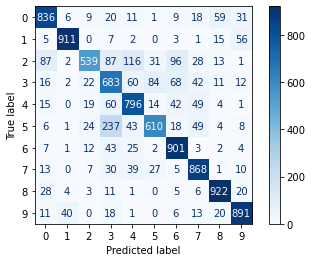

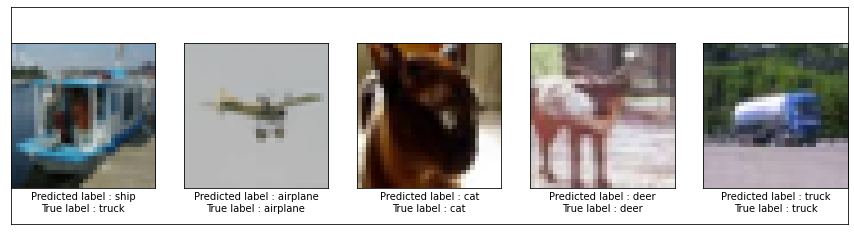

In [45]:
#Evaluating VGG19 model
Model_evaluator(model, X_test, y_test_for_evaluate)

In [53]:
#Loading Data over
(X_train, y_train, X_val, y_val, X_test, y_test) = Data_loader()

### EfficientNet

For the preprocessing, we use `efficientnet.preprocess_input` to convert the input images from RGB to BGR, and then to zero-center each color channel with respect to the ImageNet dataset, without scaling.

For the model, for fine tuning, we add 3 dense layers at the end of the model.

In separate parameter tunings, we found that the best parameters are:
- Optimizer: adam
- Number of epochs: 20
- Batch size: 256

## Preprocessing

In [54]:
#Preprocessing for VGG19
def EfficientNetB0_preprocess(input_images):
    input_images = input_images.astype('float32')
    output_images = tf.keras.applications.efficientnet.preprocess_input(input_images)
    return output_images

X_train = EfficientNetB0_preprocess(X_train)
X_val = EfficientNetB0_preprocess(X_val)
X_test = EfficientNetB0_preprocess(X_test)

y_test_for_evaluate = y_test

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
y_val = to_categorical(y_val, 10)

## Model Definition

In [60]:
#Developing EfficientNetB0 model
def EfficientNetB0_model():
    inputs = tf.keras.layers.Input(shape=(32,32,3))

    base_model = tf.keras.applications.efficientnet.EfficientNetB0(input_shape=(32, 32, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
    
    new_leyers = tf.keras.layers.GlobalAveragePooling2D()(base_model)
    new_leyers = tf.keras.layers.Flatten()(new_leyers)
    new_leyers = tf.keras.layers.Dense(512, activation="relu")(new_leyers)
    new_leyers = tf.keras.layers.Dense(256, activation="relu")(new_leyers)
    new_leyers = tf.keras.layers.Dense(10, activation="softmax", name="classification")(new_leyers)

    model = tf.keras.Model(inputs=inputs, outputs = new_leyers)
    #Like VGG adam worked better
    model.compile(optimizer='adam', 
                loss='categorical_crossentropy',
                metrics = ['accuracy'])
    return model


model = EfficientNetB0_model()
model.summary()

Model: "functional_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 1, 1, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d_14  (None, 1280)              0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 1280)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 512)               655872    
_________________________________________________________________
dense_29 (Dense)             (None, 256)               131328    
_________________________________________________________________
classification (Dense)       (None, 10)              

## Training

In [61]:
#Learning EfficientNetB0 model
#Like VGG batch size helped the model
EPOCHS = 20
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data = (X_val, y_val), batch_size=256)

Epoch 1/20
157/157 [==============================] - 10s 63ms/step - loss: 1.0702 - accuracy: 0.6276 - val_loss: 0.7871 - val_accuracy: 0.7322
Epoch 2/20
157/157 [==============================] - 8s 53ms/step - loss: 0.5919 - accuracy: 0.7962 - val_loss: 0.6289 - val_accuracy: 0.7909
Epoch 3/20
157/157 [==============================] - 8s 53ms/step - loss: 0.4248 - accuracy: 0.8524 - val_loss: 0.6179 - val_accuracy: 0.7984
Epoch 4/20
157/157 [==============================] - 8s 53ms/step - loss: 0.3279 - accuracy: 0.8853 - val_loss: 0.6513 - val_accuracy: 0.8063
Epoch 5/20
157/157 [==============================] - 8s 53ms/step - loss: 0.2619 - accuracy: 0.9082 - val_loss: 0.6313 - val_accuracy: 0.8089
Epoch 6/20
157/157 [==============================] - 8s 53ms/step - loss: 0.2134 - accuracy: 0.9269 - val_loss: 0.7366 - val_accuracy: 0.7964
Epoch 7/20
157/157 [==============================] - 8s 54ms/step - loss: 0.1777 - accuracy: 0.9391 - val_loss: 0.7291 - val_accuracy: 0.807

## Evaluation

Accuracy: 0.8125
Precision: 0.8209
Recall: 0.8125
F1 Score: 0.8138


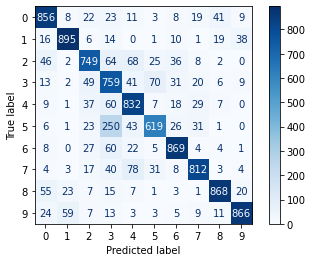

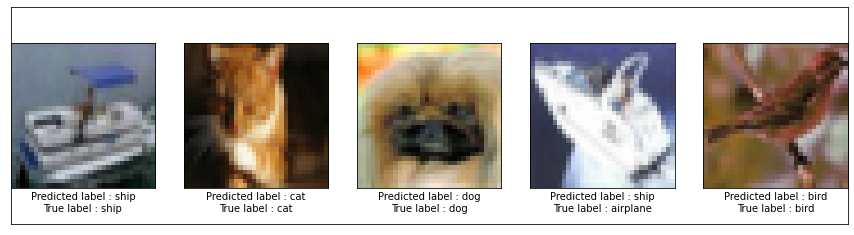

In [64]:
#Evaluating EfficientNetB0 model
Model_evaluator(model, X_test, y_test_for_evaluate)

In [74]:
#Loading Data over
(X_train, y_train, X_val, y_val, X_test, y_test) = Data_loader()

### MobileNet

For the preprocessing, we use `mobilenet.preprocess_input` to convert the input images from RGB to BGR, and then to zero-center each color channel with respect to the ImageNet dataset, without scaling.

For the model, to stop overfitting, we only add one leyer at the end of the model. additionaly, to stop overfitting even more, we use l2 regularization and 0.5 drop out on the last layer, too.

In separate parameter tunings, we found that the best parameters are:
- Optimizer: adam
- Number of epochs: 50
- Batch size: 512

## Preprocessing

In [75]:
#Preprocessing for MobileNetV2
def MobileNetV2_preprocess(input_images):
    input_images = input_images.astype('float32')
    output_images = tf.keras.applications.mobilenet_v2.preprocess_input(input_images)
    return output_images

X_train = MobileNetV2_preprocess(X_train)
X_val = MobileNetV2_preprocess(X_val)
X_test = MobileNetV2_preprocess(X_test)

y_test_for_evaluate = y_test

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
y_val = to_categorical(y_val, 10)

## Model Definition

In [92]:
#Developing MobileNetV2 model
def MobileNetV2_model():
    inputs = tf.keras.layers.Input(shape=(32,32,3))

    base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(32, 32, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
    
    new_leyers = tf.keras.layers.GlobalAveragePooling2D()(base_model)
    new_leyers = tf.keras.layers.Flatten()(new_leyers)
    #Regularization to stop overfitting
    new_leyers = tf.keras.layers.Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(new_leyers)
    #Drop out to stop overfitting
    new_leyers = tf.keras.layers.Dropout(0.5)(new_leyers)
    new_leyers = tf.keras.layers.Dense(10, activation="softmax", name="classification")(new_leyers)

    model = tf.keras.Model(inputs=inputs, outputs = new_leyers)
    model.compile(optimizer='adam', 
                loss='categorical_crossentropy',
                metrics = ['accuracy'])
    return model


model = MobileNetV2_model()
model.summary()

Model: "functional_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_61 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 1, 1, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_28  (None, 1280)              0         
_________________________________________________________________
flatten_28 (Flatten)         (None, 1280)              0         
_________________________________________________________________
dense_54 (Dense)             (None, 512)               655872    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
classification (Dense)       (None, 10)              

## Training

In [93]:
#Learning MobileNetV2 model
#Like VGG batch size helped the model
EPOCHS = 50
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data = (X_val, y_val), batch_size=512)

Epoch 1/50
79/79 [==============================] - 6s 71ms/step - loss: 5.4101 - accuracy: 0.4857 - val_loss: 4.6127 - val_accuracy: 0.2512
Epoch 2/50
79/79 [==============================] - 5s 58ms/step - loss: 1.4620 - accuracy: 0.6988 - val_loss: 6.4582 - val_accuracy: 0.2225
Epoch 3/50
79/79 [==============================] - 4s 57ms/step - loss: 0.8103 - accuracy: 0.7706 - val_loss: 5.6539 - val_accuracy: 0.2414
Epoch 4/50
79/79 [==============================] - 4s 57ms/step - loss: 0.6132 - accuracy: 0.8174 - val_loss: 7.5627 - val_accuracy: 0.1829
Epoch 5/50
79/79 [==============================] - 4s 57ms/step - loss: 0.5188 - accuracy: 0.8489 - val_loss: 5.4429 - val_accuracy: 0.2084
Epoch 6/50
79/79 [==============================] - 4s 57ms/step - loss: 0.4883 - accuracy: 0.8588 - val_loss: 5.3809 - val_accuracy: 0.2416
Epoch 7/50
79/79 [==============================] - 4s 57ms/step - loss: 0.4131 - accuracy: 0.8816 - val_loss: 3.3687 - val_accuracy: 0.3817
Epoch 8/50
79

## Evaluating

Accuracy: 0.6758
Precision: 0.7095
Recall: 0.6758
F1 Score: 0.6666


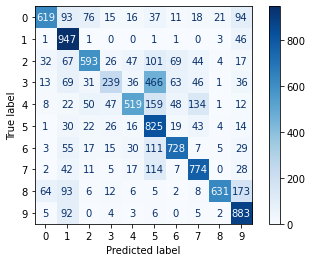

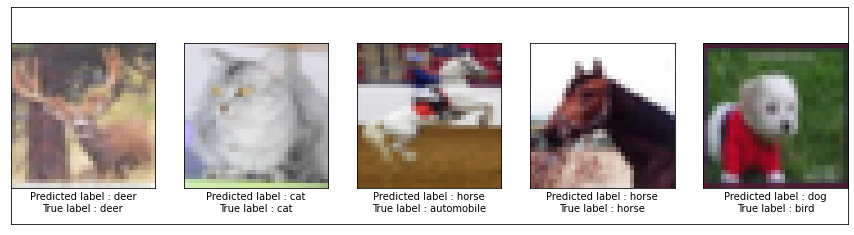

In [95]:
#Evaluating MobileNetV2 model
Model_evaluator(model, X_test, y_test_for_evaluate)

In [96]:
#Loading Data over
(X_train, y_train, X_val, y_val, X_test, y_test) = Data_loader()


### DenseNet

For the preprocessing, we use `densenet.preprocess_input` to convert the input images from RGB to BGR, and then to zero-center each color channel with respect to the ImageNet dataset, without scaling.

For the model, to stop overfitting, we add two leyers instead of three, at the end of the model. additionaly, to stop overfitting even more, we use a 0.5 drop out on the last layer.

In separate parameter tunings, we found that the best parameters are:
- Optimizer: SGD
- Number of epochs: 30
- Batch size: 128

## Preprocessing

In [97]:
#Preprocessing for DenseNet169
def DenseNet169_preprocess(input_images):
    input_images = input_images.astype('float32')
    output_images = tf.keras.applications.densenet.preprocess_input(input_images)
    return output_images

X_train = DenseNet169_preprocess(X_train)
X_val = DenseNet169_preprocess(X_val)
X_test = DenseNet169_preprocess(X_test)

y_test_for_evaluate = y_test

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
y_val = to_categorical(y_val, 10)

## Model Definition

In [106]:
#Developing DenseNet169 model
def DenseNet169_model():
    inputs = tf.keras.layers.Input(shape=(32,32,3))

    base_model = tf.keras.applications.densenet.DenseNet169(input_shape=(32, 32, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
    
    new_leyers = tf.keras.layers.GlobalAveragePooling2D()(base_model)
    new_leyers = tf.keras.layers.Flatten()(new_leyers)
    new_leyers = tf.keras.layers.Dense(1024, activation="relu")(new_leyers)
    new_leyers = tf.keras.layers.Dense(256, activation="relu")(new_leyers)
    new_leyers = tf.keras.layers.Dropout(0.5)(new_leyers)
    new_leyers = tf.keras.layers.Dense(10, activation="softmax", name="classification")(new_leyers)

    model = tf.keras.Model(inputs=inputs, outputs = new_leyers)
    model.compile(optimizer='SGD', 
                loss='categorical_crossentropy',
                metrics = ['accuracy'])
    return model


model = DenseNet169_model()
model.summary()

Model: "functional_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_71 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
densenet169 (Functional)     (None, 1, 1, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d_33  (None, 1664)              0         
_________________________________________________________________
flatten_33 (Flatten)         (None, 1664)              0         
_________________________________________________________________
dense_62 (Dense)             (None, 1024)              1704960   
_________________________________________________________________
dense_63 (Dense)             (None, 256)               262400    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)             

## Training

In [107]:
#Learning DenseNet169 model
#More complexity, less batch size
EPOCHS = 30
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data = (X_val, y_val), batch_size=128)

Epoch 1/30
313/313 [==============================] - 25s 78ms/step - loss: 1.3596 - accuracy: 0.5317 - val_loss: 0.8221 - val_accuracy: 0.7261
Epoch 2/30
313/313 [==============================] - 21s 68ms/step - loss: 0.7182 - accuracy: 0.7597 - val_loss: 0.6437 - val_accuracy: 0.7832
Epoch 3/30
313/313 [==============================] - 21s 67ms/step - loss: 0.5143 - accuracy: 0.8285 - val_loss: 0.5660 - val_accuracy: 0.8123
Epoch 4/30
313/313 [==============================] - 21s 68ms/step - loss: 0.3758 - accuracy: 0.8771 - val_loss: 0.5756 - val_accuracy: 0.8161
Epoch 5/30
313/313 [==============================] - 21s 68ms/step - loss: 0.2768 - accuracy: 0.9089 - val_loss: 0.5716 - val_accuracy: 0.8280
Epoch 6/30
313/313 [==============================] - 21s 68ms/step - loss: 0.2015 - accuracy: 0.9348 - val_loss: 0.6025 - val_accuracy: 0.8257
Epoch 7/30
313/313 [==============================] - 21s 68ms/step - loss: 0.1490 - accuracy: 0.9503 - val_loss: 0.6552 - val_accuracy:

## Evaluating

Accuracy: 0.8357
Precision: 0.8357
Recall: 0.8357
F1 Score: 0.8352


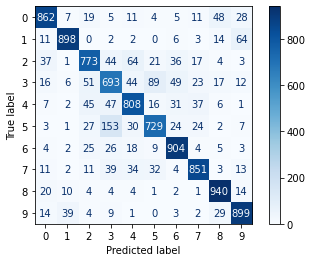

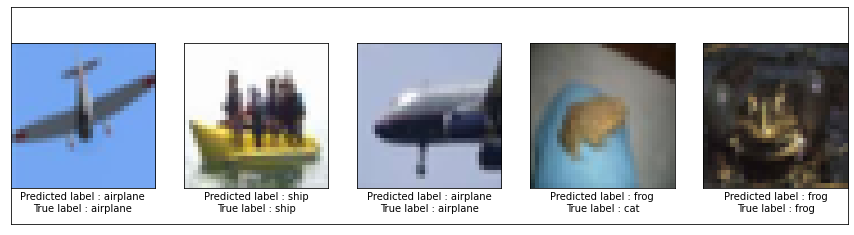

In [108]:
#Evaluating DenseNet169 model
Model_evaluator(model, X_test, y_test_for_evaluate)

In [7]:
#Loading Data over
(X_train, y_train, X_val, y_val, X_test, y_test) = Data_loader()


### ConvNet (2022)

To be able to load the pretrained weights, we first upgrade our tnesorflow. Then, for the preprocessing, we use `convnet.preprocess_input` to convert the input images from RGB to BGR, and then to zero-center each color channel with respect to the ImageNet dataset, without scaling.

For the model, to stop overfitting, we add two leyers instead of three, at the end of the model. additionaly, to stop overfitting even more, we use a 0.5 drop out on the last layer.

In separate parameter tunings, we found that the best parameters are:
- Optimizer: SGD
- Number of epochs: 10
- Batch size: 64

## Preprocessing

In [8]:
#Preprocessing for ConvNeXtBase
def ConvNeXtBase_preprocess(input_images):
    input_images = input_images.astype('float32')
    output_images = tf.keras.applications.convnext.preprocess_input(input_images)
    return output_images

X_train = ConvNeXtBase_preprocess(X_train)
X_val = ConvNeXtBase_preprocess(X_val)
X_test = ConvNeXtBase_preprocess(X_test)

y_test_for_evaluate = y_test

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
y_val = to_categorical(y_val, 10)

## Model Definition

In [9]:
#Developing ConvNeXtBase model
def ConvNeXtBase_model():
    inputs = tf.keras.layers.Input(shape=(32,32,3))

    base_model = tf.keras.applications.convnext.ConvNeXtBase(input_shape=(32, 32, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
    
    new_leyers = tf.keras.layers.GlobalAveragePooling2D()(base_model)
    new_leyers = tf.keras.layers.Flatten()(new_leyers)
    new_leyers = tf.keras.layers.Dense(512, activation="relu")(new_leyers)
    new_leyers = tf.keras.layers.Dense(128, activation="relu")(new_leyers)
    new_leyers = tf.keras.layers.Dropout(0.5)(new_leyers)
    new_leyers = tf.keras.layers.Dense(10, activation="softmax", name="classification")(new_leyers)

    model = tf.keras.Model(inputs=inputs, outputs = new_leyers)
    model.compile(optimizer='SGD', 
                loss='categorical_crossentropy',
                metrics = ['accuracy'])
    return model


model = ConvNeXtBase_model()
model.summary()

350926856/350926856 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convnext_base (Functional)      │ (None, 1, 1, 1024)     │    87,566,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification (Dense)          │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,158,218 (336.30 MB)

 Trainable params: 88,158,218 (336.30 MB)

 Non-trainable params: 0 (0.00 B)

## Training

In [10]:
#Learning ConvNeXtBase model
#More complexity, less batch size
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

EPOCHS = 10
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data = (X_val, y_val), batch_size=64)

Epoch 1/10
  2/625 ━━━━━━━━━━━━━━━━━━━━ 37s 61ms/step - accuracy: 0.1133 - loss: 2.9732   

I0000 00:00:1718141237.035139     108 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718141237.115770     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718141237.116256     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718141237.116834     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718141237.117658     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718141237.118196     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718141237.130277     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3638 - loss: 1.8047

W0000 00:00:1718141277.300228     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718141277.300758     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718141277.301295     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


625/625 ━━━━━━━━━━━━━━━━━━━━ 93s 76ms/step - accuracy: 0.3640 - loss: 1.8040 - val_accuracy: 0.7448 - val_loss: 0.7353
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.7462 - loss: 0.7637 - val_accuracy: 0.8129 - val_loss: 0.5453
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.8304 - loss: 0.5236 - val_accuracy: 0.8228 - val_loss: 0.5281
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.8738 - loss: 0.3875 - val_accuracy: 0.8493 - val_loss: 0.4563
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.9027 - loss: 0.2952 - val_accuracy: 0.8650 - val_loss: 0.4261
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.9267 - loss: 0.2283 - val_accuracy: 0.8720 - val_loss: 0.4144
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.9438 - loss: 0.1733 - val_accuracy: 0.8719 - val_loss: 0.4373
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.9567 - loss: 0.1385 - val_accurac

## Evaluating

 13/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step

W0000 00:00:1718141606.179734     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718141606.180112     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718141606.180677     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/step
Accuracy: 0.8653
Precision: 0.8722
Recall: 0.8653
F1 Score: 0.8660


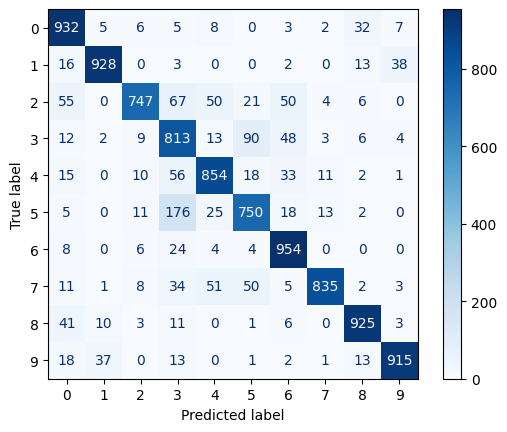

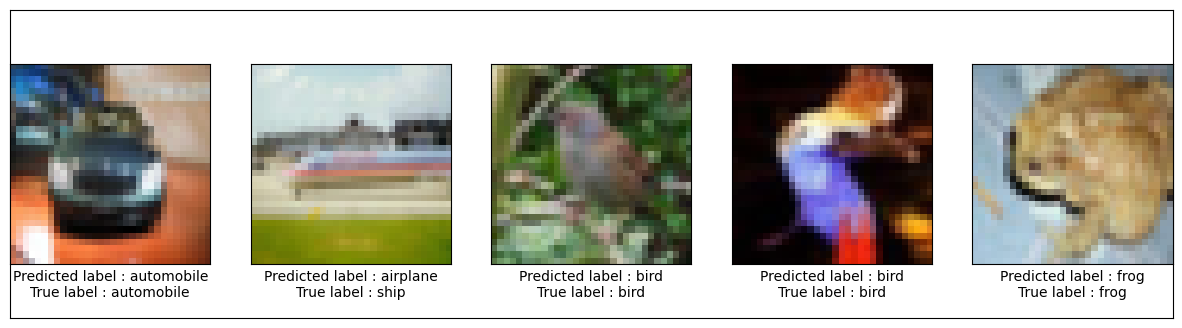

In [11]:
#Evaluating ConvNeXtBase model
Model_evaluator(model, X_test, y_test_for_evaluate)

## Building and Training GoogleNet with PyTorch

We first import newly neccessary libraries, and then load out data into transformers.

After having data, we first develop Inception blocks and then we build our model based on the blocks.

For the learning, we learn for 50 epochs and we use AdamW optimizer.

## Imports

In [1]:
#Import necessary libraries for googleNet model
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
import matplotlib.pyplot as plt
import random
import numpy as np

## Loading Data

In [2]:
DATA_PATH = '../data/'
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
#Loading Data
train_set = CIFAR10(root=DATA_PATH, train=True, download=True)
DATA_MEAN = (train_set.data / 255.0).mean((0,1,2)) 
DATA_STD = (train_set.data / 255.0).std((0,1,2))
DATA_MEAN, DATA_STD

Extracting ../data/cifar-10-python.tar.gz to ../data/


(array([0.49139968, 0.48215841, 0.44653091]),
 array([0.24703223, 0.24348513, 0.26158784]))

In [4]:
#Deviding the data
test_transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(DATA_MEAN, DATA_STD)])

train_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(DATA_MEAN, DATA_STD),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.RandomResizedCrop((32,32),scale=(0.8,1.0),ratio=(0.9,1.1))])

train_dataset = CIFAR10(root=DATA_PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(root=DATA_PATH, train=True, transform=test_transform, download=True)
test_set = CIFAR10(root=DATA_PATH, train=False, transform=test_transform, download=True)

train_set, _ = data.random_split(train_dataset, [45000, 5000])
_, val_set = data.random_split(val_dataset, [45000, 5000])

batch_size = 128
train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True, num_workers=8)
val_loader = data.DataLoader(val_set, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=8)
test_loader = data.DataLoader(test_set, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=8)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## Defining Inception blocks

In [5]:
#Developing Inception blocks
class InceptionBlock(nn.Module):
    def __init__(self, c_in, c_red: dict, c_out: dict):
        super().__init__()
        
        # 1x1 branch
        self.conv_1x1 = nn.Sequential(nn.Conv2d(c_in, c_out["1x1"], kernel_size=1),
                                     nn.BatchNorm2d(c_out["1x1"]),
                                     nn.ReLU())
        
        # 3x3 branch, we padding 1 in the 3x3 convolution layer to keep same size of image
        self.conv_3x3 = nn.Sequential(nn.Conv2d(c_in, c_red["3x3"], kernel_size=1),
                                     nn.BatchNorm2d(c_red["3x3"]),
                                     nn.ReLU(),
                                     nn.Conv2d(c_red["3x3"], c_out["3x3"], kernel_size=3, padding=1),
                                     nn.BatchNorm2d(c_out["3x3"]),
                                     nn.ReLU())
        
        # 5x5 branch, we padding 2 in the 5x5 convolution layer to keep same size of image
        self.conv_5x5 = nn.Sequential(nn.Conv2d(c_in, c_red["5x5"], kernel_size=1),
                                     nn.BatchNorm2d(c_red["5x5"]),
                                     nn.ReLU(),
                                     nn.Conv2d(c_red["5x5"], c_out["5x5"], kernel_size=5, padding=2),
                                     nn.BatchNorm2d(c_out["5x5"]),
                                     nn.ReLU())        
        # Max pooling branch
        self.max_pool = nn.Sequential(nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
                                     nn.Conv2d(c_in, c_out["max"], kernel_size=1),
                                     nn.BatchNorm2d(c_out["max"]),
                                     nn.ReLU())
        
    def forward(self, x):
        x_1x1 = self.conv_1x1(x)
        x_3x3 = self.conv_3x3(x)
        x_5x5 = self.conv_5x5(x)
        x_max = self.max_pool(x)
        output = torch.cat([x_1x1, x_3x3, x_5x5, x_max], dim=1)
        return output

## Model Definition

In [10]:
#Developing main GoogleNet model
class GoogleNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.input = nn.Sequential(nn.Conv2d(3, 64, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(64),
                                  nn.ReLU())
        
        # Stacking inception blocks
        self.inception = nn.Sequential(
            InceptionBlock(64, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 32, "5x5": 8, "max": 8}),
            InceptionBlock(64, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}),
            nn.MaxPool2d(3, stride=2, padding=1),  # 32x32 => 16x16
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 48, "5x5": 16, "max": 16}),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 48, "5x5": 16, "max": 16}),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 32, "3x3": 48, "5x5": 24, "max": 24}),
            nn.MaxPool2d(3, stride=2, padding=1),  # 16x16 => 8x8
            InceptionBlock(128, c_red={"3x3": 48, "5x5": 16}, c_out={"1x1": 32, "3x3": 64, "5x5": 16, "max": 16}),
            InceptionBlock(128, c_red={"3x3": 48, "5x5": 16}, c_out={"1x1": 32, "3x3": 64, "5x5": 16, "max": 16})
        )
        
        self.output = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        x = self.input(x)
        x = self.inception(x)
        x = self.output(x)
        return x
googleNet = GoogleNet()

## Training

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(googleNet.parameters(), 
                        lr=1e-3, 
                        weight_decay=1e-4)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, 
                                           milestones=[100, 150], 
                                           gamma=0.1)

In [12]:
n_epochs = 50
for epoch in range(n_epochs + 1):
    running_loss = 0.0 
    total = 0
    correct = 0
    for data in train_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = googleNet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    scheduler.step()
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = googleNet(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    print(f"Epoch: {epoch +1:3d}, loss: {running_loss/len(train_set)}, val_acc: {100 * correct / total:.2f}%")
    running_loss = 0.0
    
print("Training completed!")

Epoch:   1, loss: 0.010205939573711818, val_acc: 65.76%
Epoch:   2, loss: 0.006712542927265168, val_acc: 74.28%
Epoch:   3, loss: 0.005397243330213759, val_acc: 77.98%
Epoch:   4, loss: 0.004663274614678489, val_acc: 80.02%
Epoch:   5, loss: 0.00415978581044409, val_acc: 81.12%
Epoch:   6, loss: 0.0037832225720087686, val_acc: 83.32%
Epoch:   7, loss: 0.003558736488554213, val_acc: 83.58%
Epoch:   8, loss: 0.0033155616339710023, val_acc: 84.68%
Epoch:   9, loss: 0.003115383454495006, val_acc: 85.10%
Epoch:  10, loss: 0.002932573574119144, val_acc: 85.08%
Epoch:  11, loss: 0.0027935502310593922, val_acc: 85.58%
Epoch:  12, loss: 0.0026520036111275353, val_acc: 85.76%
Epoch:  13, loss: 0.002527625013391177, val_acc: 85.92%
Epoch:  14, loss: 0.0024264772570795484, val_acc: 86.50%
Epoch:  15, loss: 0.002335746763149897, val_acc: 86.98%
Epoch:  16, loss: 0.0022226002261042594, val_acc: 86.72%
Epoch:  17, loss: 0.002136235643261009, val_acc: 87.36%
Epoch:  18, loss: 0.002034467871652709, val

## Evaluation

Accuracy: 0.8892
Precision: 0.8894
Recall: 0.8892
F1 Score: 0.8891


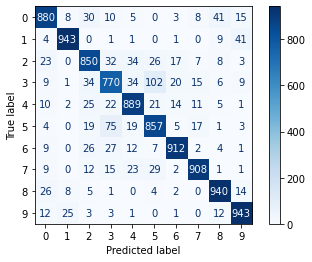

In [18]:
#Testing the model on test set
correct = 0
total = 0
y_pred = []
y_test_temp = []
X_test_temp = []

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = googleNet(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_pred.extend(predicted.cpu().numpy())
        y_test_temp.extend(labels.cpu().numpy())
        X_test_temp.extend(inputs.cpu().numpy())
        

accuracy = accuracy_score(y_test_temp, y_pred)
precision = precision_score(y_test_temp, y_pred, average='weighted')
recall = recall_score(y_test_temp, y_pred, average='weighted')
f1 = f1_score(y_test_temp, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

cm = confusion_matrix(y_test_temp, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()